In [6]:
import pickle
import os
from nltk import everygrams, ngrams, word_tokenize, FreqDist

#modelpath = os.path.join(os.path.dirname(os.path.dirname(__file__)), 'models/randomforest.pkl')
#vectpath = os.path.join(os.path.dirname(os.path.dirname(__file__)), 'models/tfid_vectorizer.pkl')
modelpath = os.path.dirname('../models/randomforest.pkl')
vectpath = os.path.dirname('../models/tfid_vectorizer.pkl')


In [7]:
#trained_model = pickle.load(open(modelpath, 'rb'))
#vectorizer = pickle.load(open(vectpath, 'rb'))


In [8]:
import matplotlib.pyplot as plt
import re
import pandas as pd
import types


## Correções

1. A correção deve ser feita em `replace_kbs()`. Deletar linhas que tenham 'itskbs' (de preferência sem ter q passar por todo o dataframe novamente)

## 1

### Exemplo de data frame

| Exemplo             | Valor do exemplo |
| ------------------- | ---------------- |
| He is asazdz friend | eita             |
| Hello               | i am aadsaz      |
| Hi                  | test             |
| Exemplo 4           | test             |

`__dataframe()`: A função é chamada quando um dataframe é passado como parâmetro para `replace_kbs(input_data,value = None,inplace=False, just_word = False)`. Se **value = KBS**, a função deve ser capaz de retornar:

- Se just_word = False:

| Exemplo   | Valor do exemplo |
| --------- | ---------------- |
| KBS       | eita             |
| Hello     | KBS              |
| Hi        | test             |
| Exemplo 4 | test             |

- Se just_word = True:

| Exemplo          | Valor do exemplo |
| ---------------- | ---------------- |
| He is KBS friend | eita             |
| Hello            | i am KBS         |
| Hi               | test             |
| Exemplo 4        | test             |

- Se value não é passado (**value = None**):
  - Se just_word = False: A linha em questão é apagada

| Exemplo   | Valor do exemplo |
| --------- | ---------------- |
| Hi        | test             |
| Exemplo 4 | test             |

- Se just_word = True: A palavra que é kbs é apagada

| Exemplo      | Valor do exemplo |
| ------------ | ---------------- |
| He is friend | eita             |
| Hello        | i am             |
| Hi           | test             |
| Exemplo 4    | test             |

Isso não está acontecendo e pode ser observado executando:

```python:
palavras = {"data":["Douglas is a nice man", "my friend", 54, "thought", "interesting", "kjadlsjda", "world", "aaaaaaa", "vessel"], "data2":["none", "name", "aklksda", "zzzzzz","exception", "optional", "bottle", "piooijoj", "mnfjisdh"]}
df = pd.DataFrame(palavras)

df_cpy = df

df3 = teste.replace_kbs(df_cpy, 'KBS', False, True)

displayy(df3)
```


In [28]:
class isitkbs(object):
    
    def __init__(self, model='randomforest'):
        self.model = model
    # Especifica qual modelo deve ser utilizado
    # Por padrão, usa-se o randomForest

    # Função para determinar se uma palavra é keyboardsmashing
    # A entrada deve ser uma palavra
    def is_word_kbs(self, input_data):
        if not isinstance(input_data, str):
            raise TypeError("input_data must be a string")

        with open(f'../models/{self.model}.pkl', 'rb') as f:
            trained_model = pickle.load(f)

        with open('../models/tfid_vectorizer.pkl', 'rb') as r:
            vectorizer = pickle.load(r)

        if (len(input_data) == 1):
            return 0
        input_data = [input_data]
        input_ngrams = []

        for i in range(len(input_data)):
            ngram = map(''.join, list(everygrams(input_data[i], 2, 4)))
            input_ngrams.extend(ngram)

        predprob = trained_model.predict_proba(
            vectorizer.transform(input_ngrams))[:, 1]

        prob = sum(predprob)/len(input_ngrams)
        if (prob >= 0.5):
            return 1
        else:
            return 0

    # Função para determinar quais são os keyboard smashing em uma frase
    # A entrada deve ser uma string ou uma lista de palavras
    def is_sent_kbs(self, input_data):
        mashs = []

        if type(input_data) != str and type(input_data) != list:
            return mashs

        try:
            words = input_data.split()
        except:
            words = input_data

        res = 0
        for i in range(len(words)):
            if type(words[i]) == str:
                if ' ' in words[i]:
                    mashs_partial = self.is_sent_kbs(words[i])
                    mashs.append(mashs_partial)
                else:
                    res = self.is_word_kbs(words[i])
            else:
                continue
            if res == 1:
                mashs.append(words[i])

        return mashs

    # Função que mostra a frequência de caracteres em keyboard smashing
    # A entrada deve ser uma string ou uma lista de string
    def freqkbs(self, input_data, graph=0):

        cont_char = {}

        data = self.is_sent_kbs(input_data)
        data = ' '.join(data)

        if (len(data) != 0):
            data = re.sub(r'[^\w\s]', '', data)
            sing_char = set(data)

            for i in sing_char:
                cont_char[i] = data.count(i)

            cont_char = dict(sorted(cont_char.items()))

            try:
                del cont_char[' ']
            except:
                pass

            # Plota gráfico se graph = 1 na chamda da função
            if (graph == 1):
                self.__freqgraph(cont_char)

        return cont_char

    def __freqgraph(self, cont_char):
        # Determina eixo x e eixo y
        x_axis = list(cont_char.keys())
        y_axis = list(cont_char.values())

        # Nomeia os eixos
        plt.xlabel('Caracteres')
        plt.ylabel('Frequência')

        # Plota o gráfico
        plt.bar(x_axis, y_axis)

    def replace_kbs(self, input_data, value=None, inplace=False, just_word=False):
        """ 
        Parâmetros:
        dataframe: dataframe pandas do qual os keyboard smashing vão ser substituidos.
        value: string que vai substituir os keyboard smashings, caso seja uma string vazia as linhas que apresentarem kbs serão removidas do dataframe
        inplace: se as substituições serão feitas no próprio dataframe dos parâmetros (True) ou será retornada uma cópia do df (False)
        just_word: se False, a posição toda do dataframe é substituído por value, se True somente o kbs presente na posição é substituido
        Ex: "This isdas test" -> "KBS" (just_word False)
                              -> "This KBS test" (just_word True)
        """
        value = value or "itskbs"

        """ 
        Se o tipo de entrada for um dataframe pandas, a função __dataframe é chamada para fazer o tratamento
        """
        if type(input_data) == pd.DataFrame:

            df = input_data.copy(deep=False) if inplace else input_data.copy()
            return self.__dataframe(df, value, just_word)

        """ 
        Se o tipo de entrada for uma lista ou uma string de palavras, a função __listOrString é chamada
        """
        if (type(input_data) == str or type(input_data) == list):
            return self.__listOrString(input_data, value, just_word)

    def __dataframe(self, df, value, just_word):
        wordskbs = []
        nRow = df.shape[0]
        nCol = df.shape[1]
        mashsIndex = []
        for row in range(nRow):
            for col in range(nCol):
                wordskbs = self.is_sent_kbs(df.iloc[row, col])
                if (len(wordskbs) != 0):
                    if (just_word == False):
                        mashsIndex.append(row)
                    else:
                        df.iloc[row, col] = self.replace_kbs(
                            df.iloc[row, col], value)
        df.drop(mashsIndex, axis=0, inplace=True)
        df.reset_index(drop=True, inplace=True)
        return df

    def __listOrString(self, input_data, value, just_word):
        isList = True
        if (type(input_data) != list):
            isList = False
            input_data = input_data.split()

        wordskbs = self.is_sent_kbs(input_data)
        output_data = []
        for i in input_data:
            if ' ' in i:
                sent = self.__listOrString(i, value, just_word)
                if just_word:
                    output_data.append(sent)
                    continue
                elif sent != i:
                    output_data.append(value)
                    continue
            if (i not in wordskbs):
                output_data.append(i)
            elif (value != 'itskbs'):
                output_data.append(value)

        if (isList == False):
            output_data = ' '.join(output_data)
        return output_data


In [29]:
# Inicia objeto
# teste = isitkbs(model="randomforest")
teste = isitkbs(model="naivebayes")


In [11]:
teste.is_sent_kbs([23, 'xxcxzaasd friend', 'Hi', 'aspdj'])


[['xxcxzaasd'], 'aspdj']

In [12]:
teste.is_sent_kbs('aspdo asocjn')


['aspdo', 'asocjn']

{'a': 4, 'b': 4, 'r': 2, 's': 1, 't': 2, 'u': 1, 'w': 3}

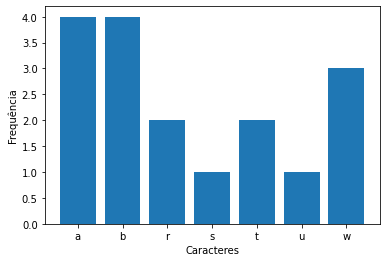

In [13]:
teste.freqkbs('This is awrubwar tawbbbast teste', graph=1)


In [14]:
teste.is_sent_kbs("Douglas is a nice man")


[]

In [26]:
palavras = {"data": ["Douglas is a  xxassds", "xxuszx friend", 54, "thought", "interesting", "kjadlsjda", "world", "aaaaaaa",
                     "vessel"], "data2": ["none", "name", "aklksda", "zzzzzz", "exception", "optional", "bottle", "piooijoj", "mnfjisdh"]}
df = pd.DataFrame(palavras)
df


,data,data2
0,Douglas is a xxassds,none
1,xxuszx friend,name
2,54,aklksda
3,thought,zzzzzz
4,interesting,exception
5,kjadlsjda,optional
6,world,bottle
7,aaaaaaa,piooijoj
8,vessel,mnfjisdh


In [30]:
# Substituir somente o kbs encontrado pela palavra APAGAR

df2 = teste.replace_kbs(df, '', inplace=False, just_word=False)

display(df2)


,data,data2
0,interesting,exception
1,world,bottle


In [17]:
# Apagar toda a linha que tenha um KBS (onde está itskbs)

df5 = teste.replace_kbs(df)

df5


,data,data2
4,interesting,exception
6,world,bottle


In [18]:
# Substitui o KBS por your
texto = teste.replace_kbs('I am qweeqrsdaa friend', 'your')

print(texto)


I am your friend


In [19]:
# Apaga o KBS da frase
frase = teste.replace_kbs('I am wwirjjaa friend')

print(frase)


I am friend


In [20]:
# Substitui uma palavra kbs por outra palavra
sub_word = teste.replace_kbs(['Hi', 'Hwrssdsx', 'Hello'], 'GoodDay')

# Deleta uma palavra kbs
del_word = teste.replace_kbs(['Hi', 'Hwrssdsx', 'Hello'])

print(sub_word)
print(del_word)


['Hi', 'GoodDay', 'Hello']
['Hi', 'Hello']


In [21]:
# Se uma lista é passada e contém uma frase, somente o kbs na frase é substituido
sub_word_sent = teste.replace_kbs(
    ['Hi', 'I am sdsaxcxz friend', 'Hello'], 'your', just_word=True)
# Se uma lista é passada e contém uma frase, a frase é substituida se contém um  ou mais kbs
sub_all_sent = teste.replace_kbs(
    ['Hi', 'I am sdsaxcxz friend', 'Hello'], 'your', just_word=False)

print(sub_word_sent)
print(sub_all_sent)


['Hi', 'I am your friend', 'Hello']
['Hi', 'your', 'Hello']


In [22]:
# Se uma lista é passada e contém uma frase, somente o kbs na frase é deletado
del_word_sent = teste.replace_kbs(
    ['Hi', 'I am sdsaxcxz friend', 'Hello'], just_word=True)
# Se uma lista é passada e contém uma frase, a frase é deletada se contém um  ou mais kbs
del_all_sent = teste.replace_kbs(
    ['Hi', 'I am sdsaxcxz friend', 'Hello'], just_word=False)

print(del_word_sent)
print(del_all_sent)


['Hi', 'I am friend', 'Hello']
['Hi', 'itskbs', 'Hello']
